In [ ]:
%%javascript
IPython.notebook.clear_all_output();

<IPython.core.display.Javascript object>

In [2]:
import sys
import tensorflow as tf
import tensorflow.keras as keras
print("Python version %s.%s.%s" % sys.version_info[:3])
print("Tensorflow version %s" % tf.__version__)
print("Keras version %s" % keras.__version__)

Python version 3.7.13
Tensorflow version 2.0.0
Keras version 2.2.4-tf


In [3]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import resnet50, vgg16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

model_resnet50 = resnet50.ResNet50(weights='imagenet', include_top=False)
model_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False)

img_width = 224
# TODO: placeholders actual values are augmentation specific
num_train_images = 1229
split_point = 983

2022-04-13 13:42:33.759106: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-13 13:42:33.759782: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.


In [4]:
import pandas as pd
labels = pd.read_csv('data/train/labels.csv', names=["id","distancing"], dtype={'id': str, 'distancing': np.uint8})
labels.head()

,id,distancing
0,0001,0
1,0002,1
2,0003,1
3,0004,0
4,0005,0


In [5]:
classes = ['not_distanced', 'distanced']

In [6]:
def get_image(filename):
    original = load_img(filename, target_size=(img_width, img_width))
    numpy_image = img_to_array(original)
    return np.uint8(numpy_image)

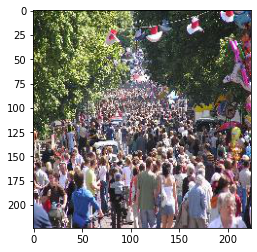

In [7]:
image = get_image('data/train/images/1227.jpg')
plt.imshow(np.uint8(image))
plt.show()

In [8]:
x_train = np.zeros((num_train_images, img_width, img_width, 3), dtype=np.uint8)
y_train = np.zeros((num_train_images, 2), dtype=np.uint8)

for i in range(num_train_images):
    # print('train/%s.jpg' % labels['id'][i])
    x_train[i] = get_image('data/train/images/%s.jpg' % labels['id'][i])
    # print(labels['distancing'][i])
    pos = labels['distancing'][i] # recall that breed is the array of classes
    y_train[i][pos] = 1
    # print(y_train[i])
    if(i % 1000 == 0): print(i, 'images loaded')

0 images loaded
1000 images loaded


In [9]:
x_train = resnet50.preprocess_input(x_train)
x_train.shape

(1229, 224, 224, 3)

In [10]:
features = model_resnet50.predict(x_train, batch_size=64, verbose=1)

1229/1229 [==============================] - 135s 110ms/sample


In [11]:
features.shape

(1229, 7, 7, 2048)

In [12]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(2, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.

In [13]:
model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 7, 7, 2048)]      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               1024500   
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               2000      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0     

In [14]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [15]:
early_stop = EarlyStopping(monitor='val_loss',  patience=5, verbose=1)

history = model.fit(features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)

Train on 983 samples, validate on 246 samples
Epoch 1/30
983/983 [==============================] - 1s 1ms/sample - loss: 0.4212 - accuracy: 0.8118 - val_loss: 0.1887 - val_accuracy: 0.9472
Epoch 2/30
983/983 [==============================] - 0s 370us/sample - loss: 0.1289 - accuracy: 0.9563 - val_loss: 0.1575 - val_accuracy: 0.9472
Epoch 3/30
983/983 [==============================] - 0s 342us/sample - loss: 0.0981 - accuracy: 0.9634 - val_loss: 0.1253 - val_accuracy: 0.9553
Epoch 4/30
983/983 [==============================] - 0s 346us/sample - loss: 0.0746 - accuracy: 0.9685 - val_loss: 0.0619 - val_accuracy: 0.9797
Epoch 5/30
983/983 [==============================] - 0s 337us/sample - loss: 0.0504 - accuracy: 0.9786 - val_loss: 0.0433 - val_accuracy: 0.9756
Epoch 6/30
983/983 [==============================] - 0s 363us/sample - loss: 0.0518 - accuracy: 0.9797 - val_loss: 0.0407 - val_accuracy: 0.9878
Epoch 7/30
983/983 [==============================] - 0s 330us/sample - loss: 0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


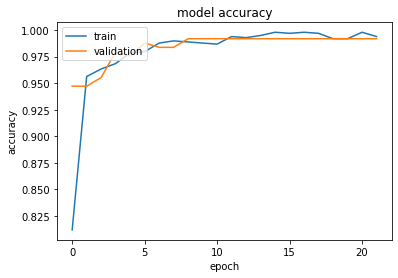

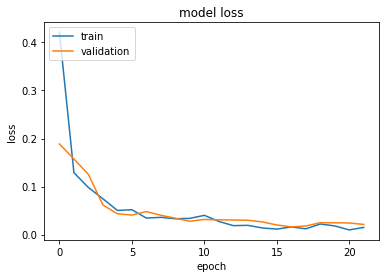

In [16]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
model.save('resnet50.h5')

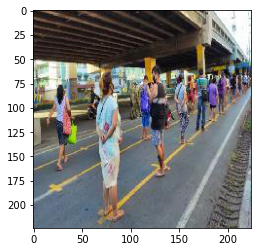

In [18]:
test_img = get_image('data/test/images/1247.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [19]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions

image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

image_batch = resnet50.preprocess_input(image_batch)
feature_input = model_resnet50.predict(image_batch)
predictions = model.predict(feature_input)
pos = np.argmax(predictions)
classes[pos]

'distanced'

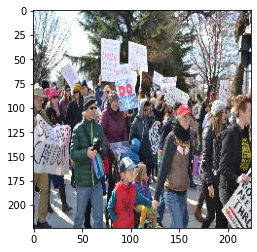

In [20]:
test_img = get_image('data/test/images/1232.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [21]:
image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

image_batch = resnet50.preprocess_input(image_batch)
feature_input = model_resnet50.predict(image_batch)
predictions = model.predict(feature_input)
pos = np.argmax(predictions)
classes[pos]

'not_distanced'

In [22]:
num_test_images = 310

x_test = np.zeros((num_test_images, img_width, img_width, 3), dtype=np.uint8)
y_test = np.zeros((num_test_images, 2), dtype=np.uint8)

test_labels = pd.read_csv('data/test/labels.csv', names=["id","distancing"], dtype={'id': str, 'distancing': np.uint8})
test_labels.head()

,id,distancing
0,1230,0
1,1231,1
2,1232,0
3,1233,0
4,1234,1


In [24]:
for i in range(num_test_images):
    # print('test/%s.jpg' % labels['id'][i])
    x_test[i] = get_image('data/test/images/%s.jpg' % test_labels['id'][i])
    # print(test_labels['distancing'][i])
    pos = test_labels['distancing'][i] # recall that breed is the array of classes
    y_test[i][pos] = 1
    # print(y_train[i])
    if(i % 100 == 0): print(i, 'images loaded')

0 images loaded
100 images loaded
200 images loaded
300 images loaded


In [25]:
x_test = resnet50.preprocess_input(x_test)
x_test.shape

(310, 224, 224, 3)

In [45]:
feature_input = model_resnet50.predict(x_test)
predictions = model.predict(feature_input)
type(predictions)

numpy.ndarray

In [51]:
preds = np.zeros((num_test_images, 2), dtype=np.uint8)
preds[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1
preds = np.nonzero(preds)
preds = preds[1]
preds[:5]

array([0, 1, 0, 0, 1])

In [53]:
y_truth = np.zeros((num_test_images, 2), dtype=np.uint8)
y_truth[np.arange(y_test.shape[0]), np.argmax(y_test, axis=1)] = 1
y_truth = np.nonzero(y_truth)
y_truth = y_truth[1]
y_truth[:5]

array([0, 1, 0, 0, 1])

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
matrix = confusion_matrix(y_truth, preds)
print(matrix)

[[197   3]
 [ 11  99]]


In [57]:
precision = precision_score(y_truth, preds)
print('Precision: %f' % precision)
recall = recall_score(y_truth, preds)
print('Recall: %f' % recall)
f1 = f1_score(y_truth, preds)
print('F1 score: %f' % f1)

Precision: 0.970588
Recall: 0.900000
F1 score: 0.933962


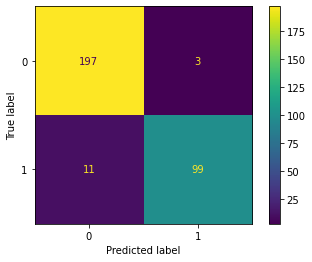

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_truth, preds)

In [225]:
from matplotlib import cm
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore, CategoricalScore

In [226]:
saliency_img = get_image('data/test/images/1247.jpg')
saliency_imgs = []
for num in range(16):    
    saliency_imgs.append(saliency_img)
saliency_imgs = np.asarray(saliency_imgs)
print(saliency_imgs.shape)
scores = [281, 282, 283, 284, 286, 287, 366, 367, 341, 273, 270, 470, 188, 130, 361, 364]
score = CategoricalScore(scores)

(16, 224, 224, 3)


In [227]:
X = resnet50.preprocess_input(saliency_imgs)
replace2linear = ReplaceToLinear()

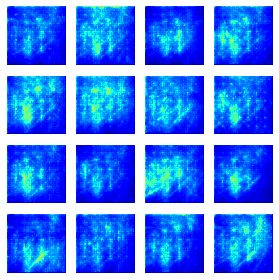

In [228]:
saliency = Saliency(model_resnet50, model_modifier=replace2linear, clone=True)

saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20)
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(4, 4))
count = 0
for row in range(4):
    for col in range(4):
        ax[row, col].imshow(saliency_map[count], cmap='jet')
        ax[row, col].axis('off')
        count+=1
plt.tight_layout()
plt.show()

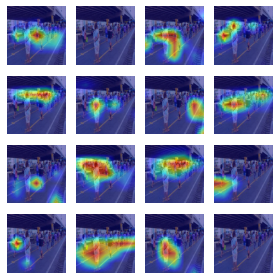

In [229]:
# Create Gradcam object
gradcam = Gradcam(model_resnet50, model_modifier=replace2linear, clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score, X, penultimate_layer=-1)

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(4, 4))
count = 0
for row in range(4):
    for col in range(4):
        heatmap = np.uint8(cm.jet(cam[count])[..., :3] * 255)
        ax[row, col].imshow(get_image('data/test/images/1247.jpg'))
        ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        ax[row, col].axis('off')
        count+=1
plt.tight_layout()
plt.show()

In [60]:
x_train = vgg16.preprocess_input(x_train)
x_train.shape

(1229, 224, 224, 3)

In [61]:
features = model_vgg16.predict(x_train, batch_size=64, verbose=1)

1229/1229 [==============================] - 330s 268ms/sample


In [62]:
features.shape

(1229, 7, 7, 512)

In [63]:
inputs = Input(shape = (7, 7, 512)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(2, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.

In [64]:
model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 7, 7, 512)]       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               256500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0   

In [65]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [66]:
early_stop = EarlyStopping(monitor='val_loss',  patience=5, verbose=1)

history = model.fit(features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)

Train on 983 samples, validate on 246 samples
Epoch 1/30
983/983 [==============================] - 1s 1ms/sample - loss: 0.5772 - accuracy: 0.7304 - val_loss: 0.4344 - val_accuracy: 0.8821
Epoch 2/30
983/983 [==============================] - 0s 180us/sample - loss: 0.3240 - accuracy: 0.8647 - val_loss: 0.2810 - val_accuracy: 0.9268
Epoch 3/30
983/983 [==============================] - 0s 177us/sample - loss: 0.2671 - accuracy: 0.8952 - val_loss: 0.1898 - val_accuracy: 0.9553
Epoch 4/30
983/983 [==============================] - 0s 174us/sample - loss: 0.2186 - accuracy: 0.9023 - val_loss: 0.1373 - val_accuracy: 0.9593
Epoch 5/30
983/983 [==============================] - 0s 177us/sample - loss: 0.1760 - accuracy: 0.9369 - val_loss: 0.1261 - val_accuracy: 0.9553
Epoch 6/30
983/983 [==============================] - 0s 172us/sample - loss: 0.1723 - accuracy: 0.9400 - val_loss: 0.1108 - val_accuracy: 0.9553
Epoch 7/30
983/983 [==============================] - 0s 173us/sample - loss: 0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


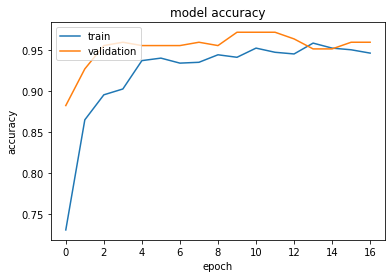

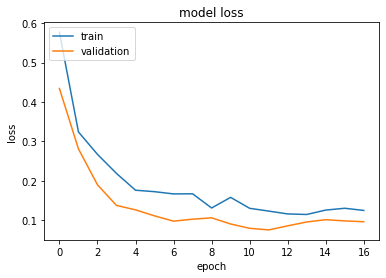

In [67]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [68]:
model.save('vgg16.h5')

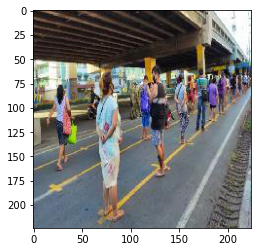

In [69]:
test_img = get_image('data/test/images/1247.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [70]:
image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

image_batch = vgg16.preprocess_input(image_batch)
feature_input = model_vgg16.predict(image_batch)
predictions = model.predict(feature_input)
pos = np.argmax(predictions)
classes[pos]

'distanced'

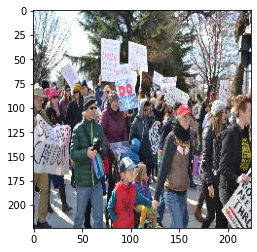

In [71]:
test_img = get_image('data/test/images/1232.jpg')
plt.imshow(np.uint8(test_img))
plt.show()

In [72]:
image_batch = np.expand_dims(test_img, axis=0)
image_batch = np.copy(image_batch)

image_batch = vgg16.preprocess_input(image_batch)
feature_input = model_vgg16.predict(image_batch)
predictions = model.predict(feature_input)
pos = np.argmax(predictions)
classes[pos]

'not_distanced'

In [73]:
x_test = vgg16.preprocess_input(x_test)
x_test.shape

(310, 224, 224, 3)

In [74]:
feature_input = model_vgg16.predict(x_test)
predictions = model.predict(feature_input)
type(predictions)

numpy.ndarray

In [75]:
preds = np.zeros((num_test_images, 2), dtype=np.uint8)
preds[np.arange(predictions.shape[0]), np.argmax(predictions, axis=1)] = 1
preds = np.nonzero(preds)
preds = preds[1]
preds[:5]

array([0, 1, 0, 0, 1])

In [76]:
matrix = confusion_matrix(y_truth, preds)
print(matrix)

[[189  11]
 [ 13  97]]


In [77]:
precision = precision_score(y_truth, preds)
print('Precision: %f' % precision)
recall = recall_score(y_truth, preds)
print('Recall: %f' % recall)
f1 = f1_score(y_truth, preds)
print('F1 score: %f' % f1)

Precision: 0.898148
Recall: 0.881818
F1 score: 0.889908


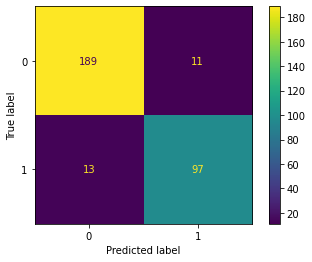

In [78]:
ConfusionMatrixDisplay.from_predictions(y_truth, preds)

In [221]:
X = vgg16.preprocess_input(saliency_imgs)
replace2linear = ReplaceToLinear()

(16, 224, 224, 3)


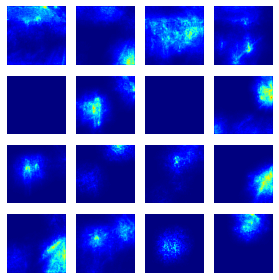

In [222]:
saliency = Saliency(model_vgg16, model_modifier=replace2linear, clone=True)

saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20)
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(4, 4))
count = 0
for row in range(4):
    for col in range(4):
        ax[row, col].imshow(saliency_map[count], cmap='jet')
        ax[row, col].axis('off')
        count+=1
plt.tight_layout()
plt.show()

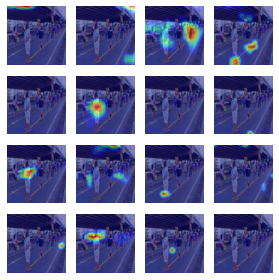

In [224]:
# Create Gradcam object
gradcam = Gradcam(model_vgg16, model_modifier=replace2linear, clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score, X, penultimate_layer=-1)

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(4, 4))
count = 0
for row in range(4):
    for col in range(4):
        heatmap = np.uint8(cm.jet(cam[count])[..., :3] * 255)
        ax[row, col].imshow(get_image('data/test/images/1247.jpg'))
        ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        ax[row, col].axis('off')
        count+=1
plt.tight_layout()
plt.show()